Comments:
Maybe adjust sent preprocessing to keep some punctuation in that may be meaningful (exclamations, sad face, etc)

##Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pwd
# Change directory
%cd ../content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
!pwd

/content
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0


##Setup

### Libraries

In [3]:
import nltk
nltk.download('punkt')
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
from os import getcwd
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Import util functions

In [4]:
!pip install import-ipynb
import import_ipynb

#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.0 MB/s 


In [5]:
%cd ./utils
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
module = drive.CreateFile({'id':'1pegou5Ag0hDIKk6Y1wS9uwegE6oBTfZJ'})
module.GetContentFile('DataPrep.ipynb')
import DataPrep 

/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0/utils
importing Jupyter notebook from DataPrep.ipynb


In [6]:
%cd ../

/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0


###Load Data

In [7]:
posneg_sent = pd.read_csv("data/posneg_sent.csv") # positive/negative word frequencies
sent = pd.read_csv("data/sent.csv") # sentences ds
print(sent.head())
posneg_sent = posneg_sent.iloc[:,1:]
print(posneg_sent.head(3))

#replace nan with empty string
sent["clean_tweet_root"] = sent["clean_tweet_root"].fillna("")

   Unnamed: 0                                               text  target  \
0           0  Our Deeds are the Reason of this #earthquake M...       1   
1           1             Forest fire near La Ronge Sask. Canada       1   
2           2  All residents asked to 'shelter in place' are ...       1   
3           3  13,000 people receive #wildfires evacuation or...       1   
4           4  Just got sent this photo from Ruby #Alaska as ...       1   

                                         clean_tweet  \
0       deeds reason earthquake may allah forgive us   
1              forest fire near la ronge sask canada   
2  residents asked shelter place notified officer...   
3    people receive wildfires evacuation orders c...   
4  got sent photo ruby alaska smoke wildfires pou...   

                                    clean_tweet_root  
0          deed reason earthquak may allah forgiv us  
1               forest fire near la rong sask canada  
2  resid ask shelter place notifi offic e

In [8]:
# Split the data on train & test
X_train, X_test, y_train, y_test = train_test_split(sent.clean_tweet_root, sent.target, test_size=0.3, random_state=0)
print(X_train.head())
print(y_train.head())

476      everyon see ignorancesh latinoand ever benoth...
4854    white peopl know worri tirelessli black black ...
4270                  chilli heat wave dorito never fail 
992                           skim twitter miss bodi bag 
4475     hot c  special modifi land stadium rescu host...
Name: clean_tweet_root, dtype: object
476     0
4854    1
4270    0
992     0
4475    1
Name: target, dtype: int64


##Process Data

In [9]:
# Count tweets - creates dictionary of (word,target) frequencies
def count_tweets(tweets, ys):
    result = {}
    for y, tweet in zip(ys, tweets):
        for word in word_tokenize(tweet):
            # define the key, which is the word and label tuple
            pair = (word,y)
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
    return result

In [10]:
freqs = count_tweets(X_train, y_train)

## Train model using Naive Bayes

In [11]:
# Extracts frequesncy from the dictinoray for a given word
def lookup(freqs,word,tgt):
    pair = (word,tgt)
    if pair in freqs.keys():
      freq = freqs[pair]
    else:
      freq = 0
    return freq

In [12]:
# Calculates log prior and loglikelihoods for each word
def train_naive_bayes(freqs, train_x, train_y):
    loglikelihood = {}
    p_w_p = {}
    p_w_n = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([i[0] for i in freqs.keys()])
    V = len(vocab)    

    # calculate N_pos, N_neg
    N_pos = sum([freqs[i] for i in freqs.keys() if i[1]==1])
    N_neg = sum([freqs[i] for i in freqs.keys() if i[1]==0])
    
    # Calculate D, the number of documents
    D = len(train_x)
    # Calculate D_pos, the number of positive documents
    D_pos = sum(train_y)
    # Calculate D_neg, the number of negative documents
    D_neg = D-D_pos
    # Calculate logprior
    logprior = np.log(D_pos/D_neg)
    
    # For each word in the vocabulary...
    p_tweet = pd.DataFrame(columns=['positive','negative','tgt'])
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word, 1)
        freq_neg = lookup(freqs,word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(N_pos+V)
        p_w_neg = (freq_neg+1)/(N_neg+V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        p_w_p[word] = p_w_pos
        p_w_n[word] = p_w_neg

    for i in range(len(train_y)):
      p_tweet.loc[i,'positive'] = 0
      p_tweet.loc[i,'negative'] = 0
      p_tweet.loc[i,'tgt'] = train_y.iloc[i]
      for w in word_tokenize(train_x.iloc[i]):
        p_tweet.loc[i,'positive'] += np.log(p_w_p[w])
        p_tweet.loc[i,'negative'] += np.log(p_w_n[w])

    return logprior, loglikelihood, p_tweet

In [13]:
logprior, loglikelihood, p_tweet = train_naive_bayes(freqs, X_train, y_train)

##Test

In [14]:
# Predict target oucome
def naive_bayes_predict(tweet, logprior, loglikelihood):
    # process the tweet to get a list of words
    word_l = word_tokenize(tweet)

    # initialize probability to zero
    p = 0
    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [15]:
# Check accuracy
def test_naive_bayes(test_x, test_y, logprior, loglikelihood, naive_bayes_predict=naive_bayes_predict):
    y_hats = [1 if naive_bayes_predict(X_test.iloc[i], logprior, loglikelihood)>0 else 0 for i in range(len(X_test))]

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum(abs(y_hats-test_y))/len(test_y)

    # Accuracy is 1 minus the error
    accuracy = 1-error

    return accuracy


In [16]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(X_test, y_test, logprior, loglikelihood)))

Naive Bayes accuracy = 0.8117


##Get ratio of positive and negative counts

In [17]:
# Calculate ratio of positive and negative counts
def get_ratio(freqs, word):
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    # use lookup() to find positive counts for the word (denoted by the integer 1)
    pos_neg_ratio['positive'] = lookup(freqs,word,1)
    
    # use lookup() to find negative counts for the word (denoted by integer 0)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)
    
    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive']+1) / (pos_neg_ratio['negative']+1)

    return pos_neg_ratio

In [18]:
def get_words_by_threshold(freqs, label, threshold, get_ratio=get_ratio):
    word_list = {}

    for key in freqs.keys():
        word, _ = key

        # get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs, word)

        # if the label is 1 and the ratio is greater than or equal to the threshold...
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:
        
            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio['ratio']

        # If the label is 0 and the pos_neg_ratio is less than or equal to the threshold...
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:
        
            # Add the pos_neg_ratio to the dictionary
            word_list[word] = pos_neg_ratio['ratio']

        # otherwise, do not include this word in the list (do nothing)

    return word_list


In [19]:
# Find negative words at or below a threshold
get_words_by_threshold(freqs, label=0, threshold=0.09)

{'bag': 0.075,
 'bleed': 0.08333333333333333,
 'mayhem': 0.058823529411764705,
 'cat': 0.06666666666666667,
 'self': 0.08333333333333333,
 'mode': 0.07692307692307693,
 'hire': 0.08333333333333333,
 'career': 0.07142857142857142,
 'lmao': 0.08333333333333333}

In [20]:
# Find positive words at or above a threshold
get_words_by_threshold(freqs, label=1, threshold=20)

{'bestnaijamad': 21.0,
 'pkk': 20.0,
 'bomber': 20.0,
 'spill': 29.0,
 'legionnair': 46.0,
 'outbreak': 33.0,
 'northern': 44.0,
 'typhoon': 43.0,
 'mosqu': 25.0,
 'sever': 21.0,
 'hiroshima': 33.5,
 'debri': 33.0,
 'mh': 27.5,
 'malaysia': 35.0,
 'isra': 20.0,
 'migrant': 37.0}

In [21]:
# Some error analysis 
print('Truth Predicted Tweet')
for x, y in zip(X_test, y_test):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            word_tokenize(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
0	1.00	b'tix calgari flame vs col avalanch preseason scotiabank saddledom'
1	0.00	b'come later year man tattoo women novel base real serial killer arkansa amp natur disast nola'
1	0.00	b'short throw overboard think leader could much wors refuge worst pm ever'
0	1.00	b'haley lu richardson fight water last survivor review'
1	0.00	b'cartervil high school coach prepar game day injuri'
0	1.00	b'hate shatter delus hatchet deadli weapon justifi lethal forc gunsens'
1	0.00	b'ferguson riot work next time say riot chang anyth fix'
1	0.00	b'guess ok armenian sinc spent histori get annihil'
0	1.00	b'fatal'
0	1.00	b'go nuclear arm race go make rubbl bounc winston church'
1	0.00	b'glad save didnt want steal thunder p'
1	0.00	b'like could danger someth'
0	1.00	b'truck driver salvag ban tomato destruct russian border news'
1	0.00	b'readi get annihil buc game'
1	0.00	b'agre get amp vote look devast caus firstnat idlenomor cndpoli yyj'
0	1.00	b'robert conquest famin museum kiev'
0	

##Visualise

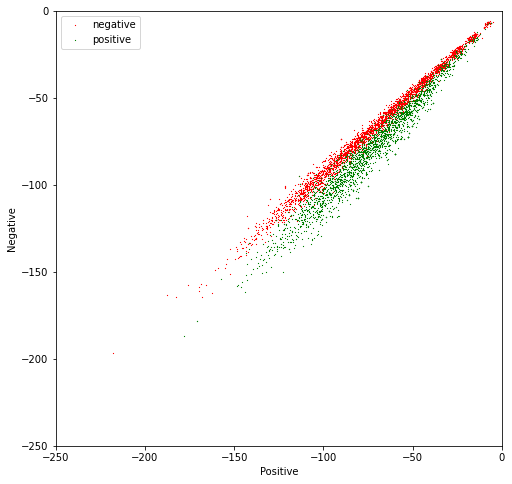

In [22]:
p_tweet
# Plot pos and neg samples
fig, ax = plt.subplots(figsize = (8, 8)) #Create a new figure with a custom size

colors = ['red', 'green'] # Define a color palete
sentiments = ['negative', 'positive'] 

index = p_tweet.index

# Color base on sentiment
for tgt in p_tweet.tgt.unique():
    ix = index[p_tweet.tgt == tgt]
    ax.scatter(p_tweet.iloc[ix].positive, p_tweet.iloc[ix].negative, c=colors[int(tgt)], s=0.1, marker='*', label=sentiments[int(tgt)])

ax.legend(loc='best')    
    
# Custom limits for this chart
plt.xlim(-250,0)
plt.ylim(-250,0)

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label
plt.show()

In [23]:
# Reference: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x.astype(float), y.astype(float))
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

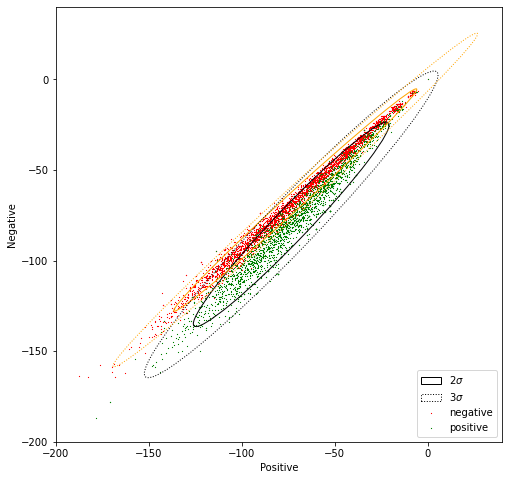

In [24]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green'] # Define a color palete
sentiments = ['negative', 'positive'] 
index = p_tweet.index

# Color base on tgt
for tgt in p_tweet.tgt.unique():
    ix = index[p_tweet.tgt == tgt]
    ax.scatter(p_tweet.iloc[ix].positive, p_tweet.iloc[ix].negative, c=colors[int(tgt)], s=0.1, marker='*', label=sentiments[int(tgt)])

# Custom limits for this chart
plt.xlim(-200,40)  
plt.ylim(-200,40)

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label

data_pos = p_tweet[p_tweet.tgt == 1] # Filter only the positive samples
data_neg = p_tweet[p_tweet.tgt == 0] # Filter only the negative samples

# Print confidence ellipses of 2 std
confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=2, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=2, edgecolor='orange')

# Print confidence ellipses of 3 std
confidence_ellipse(data_pos.positive, data_pos.negative, ax, n_std=3, edgecolor='black', linestyle=':', label=r'$3\sigma$')
confidence_ellipse(data_neg.positive, data_neg.negative, ax, n_std=3, edgecolor='orange', linestyle=':')
ax.legend(loc='lower right')

plt.show()

## Save model

In [36]:
model = []
model = model+[logprior]
model = model + [loglikelihood]

In [40]:
with open(r'NB_list.txt','w') as fp:
    for item in model:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [47]:
model1 = pd.read_csv("NB_list.txt")
model1.shape

(1, 1)